# Data-X: Airbnb Price Trend Predictor
Predicts the percentage change in price for an Airbnb in San Francisco a year from now based on historical data
___

### Dependencies
None

### Imports

In [1]:
# Import Python packages
import os
from pathlib import Path

# Import Standard ML packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib
import sklearn.linear_model as linear_model
from sklearn import ensemble
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 14

%matplotlib inline

/Users/erikyang/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Import Datasets

In [2]:
may18_df = pd.read_csv("../raw_datasets/sf_airbnb_may_18.csv")
nov18_df = pd.read_csv("../raw_datasets/sf_airbnb_nov_18.csv")
nov17_df = pd.read_csv("../raw_datasets/sf_airbnb_nov_17.csv")
nov16_df = pd.read_csv("../raw_datasets/sf_airbnb_nov_16.csv")

/Users/erikyang/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Cleaning/Transformation

In [3]:
def select_columns(df, *columns):
    return df.loc[:, columns]

def dollar_to_float(df, *columns):
    for c in columns:
        df[c] = df[c].str.replace(r'[$,]', '').astype("float64")
    return df

def one_hot_encoding(df, *columns):
    for c in columns:
        hot = pd.get_dummies(df[c], prefix=c)
        df = pd.concat([df, hot], axis=1)
        df.drop(c, axis=1, inplace=True)
    return df

def fill_na_with_median(df, *columns):
    for c in columns:
        df.loc[df[c].isnull(),c] = df.loc[df[c].notnull(),c].median()
    return df

def clean_df(df):
    df = df.copy()
    return (
        df.set_index("id").pipe(
            select_columns,
            "price",
            "longitude",
            "latitude",
            "accommodates",
            "bedrooms",
            "bathrooms",
            "beds",
            "room_type",
            "neighbourhood_cleansed",
            "zipcode"
        )
        .pipe(
            fill_na_with_median,
            "bathrooms",
            "beds"
        )
        .pipe(
            dollar_to_float,
            "price"
        )
        .pipe(
            one_hot_encoding,
            "room_type",
            "neighbourhood_cleansed",
            "zipcode"
        )
    )

def clean_df_price(df):    
    df = df.copy()
    return (
        df.set_index("id").pipe(
            select_columns,
            "price"
        ).pipe(
            dollar_to_float,
            "price"
        )
    )

def merge_dfs(*dfs):    
    for i, df in enumerate(dfs):
        if i == 0:
            merged_df = df
        else:
            merged_df = merged_df.merge(df, left_index=True, right_index=True)
    return merged_df

In [4]:
curr_df = clean_df(nov18_df)
past_df = clean_df_price(nov16_df)

merged = merge_dfs(past_df, curr_df)
merged.rename(
    index=str,
    columns={
        "price_x": "price_past",
        "price_y": "price_curr"
    },
    inplace=True
)

merged["price_percent_change"] = (merged["price_curr"] - merged["price_past"])/merged["price_past"]
merged = merged.drop(["price_curr"], axis=1)
merged.head()

,price_past,longitude,latitude,accommodates,bedrooms,bathrooms,beds,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,...,zipcode_94124.0,zipcode_94127.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0,zipcode_94510.0,zipcode_94965.0,price_percent_change
id,,,,,,,,,,,,,,,,,,,,,
6938818,111.0,-122.505635,37.780659,4,1.0,1.0,2.0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.414414
1931937,85.0,-122.494424,37.781564,2,1.0,1.0,1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.094118
2134100,135.0,-122.508557,37.783888,2,1.0,1.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.103704
8411606,105.0,-122.493162,37.786675,2,1.0,1.0,1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.238095
69681,220.0,-122.509232,37.777069,4,3.0,2.0,3.0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.227273


### Model Training/Evaluation

In [5]:
def scale_X(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

In [6]:
X_df = merged.drop("price_percent_change", axis=1)
X = X_df.pipe(scale_X)
Y = merged["price_percent_change"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8)

Linear: {'fit_intercept': True}, Error: 0.12239986373278529
Lasso: {'alpha': 1, 'fit_intercept': True}, Error: 0.05627523766487338
Ridge: {'alpha': 20, 'fit_intercept': False}, Error: 0.11286416700202086
OMP: {'fit_intercept': True}, Error: 0.11129411492258981
BayesRidge: {'alpha_1': 1e-06, 'alpha_2': 1, 'fit_intercept': True, 'lambda_1': 1, 'lambda_2': 1e-06}, Error: 0.056363333651311034
ElasticNet: {'alpha': 1, 'l1_ratio': 0.3}, Error: 0.05627523766487338
RForest: {'n_estimators': 20}, Error: 0.09899227209208811
GBoosting: {'learning_rate': 0.05, 'loss': 'lad'}, Error: 0.06719070962845825

Best Estimator: Lasso
MAE: 0.05627523766487338



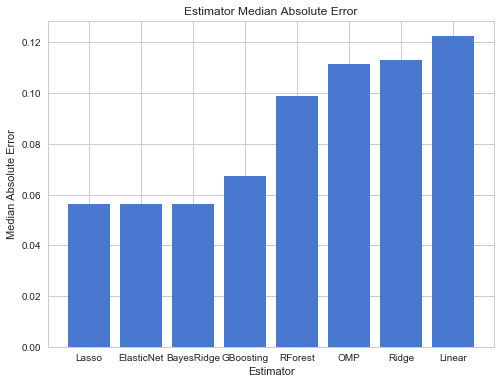

In [7]:
err_func = metrics.median_absolute_error

estimators = [
    GridSearchCV(
        estimator = linear_model.LinearRegression(),
        param_grid = {
            "fit_intercept": [True, False]
        },
        scoring = make_scorer(err_func, greater_is_better=False)
    ),
    GridSearchCV(
        estimator = linear_model.Lasso(),
        param_grid = {
            "alpha": [1, 5, 10, 20],
            "fit_intercept": [True, False]
        },
        scoring = make_scorer(err_func, greater_is_better=False)
    ),
    GridSearchCV(
        estimator = linear_model.Ridge(fit_intercept=True),
        param_grid = {
            "alpha": [1, 5, 10, 20],
            "fit_intercept": [True, False]
        },
        scoring = make_scorer(err_func, greater_is_better=False)
    ),
    GridSearchCV(
        estimator = linear_model.OrthogonalMatchingPursuit(),
        param_grid = {
            "fit_intercept": [True]
        },
        scoring = make_scorer(err_func, greater_is_better=False)
    ),
    GridSearchCV(
        estimator = linear_model.BayesianRidge(),
        param_grid = {
            "alpha_1": [1.e-6, 1],
            "alpha_2": [1.e-6, 1],
            "lambda_1": [1.e-6, 1],
            "lambda_2": [1.e-6, 1],
            "fit_intercept": [True, False]
        },
        scoring = make_scorer(err_func, greater_is_better=False)
    ),
    GridSearchCV(
        estimator = linear_model.ElasticNet(),
        param_grid = {
            "alpha": [1, 5, 10, 20],
            "l1_ratio": [0.3, 0.5, 0.7]
        },
        scoring = make_scorer(err_func, greater_is_better=False)
    ),
    GridSearchCV(
        estimator = ensemble.RandomForestRegressor(),
        param_grid = {
            "n_estimators": [5, 10, 20]
        },
        scoring = make_scorer(err_func, greater_is_better=False)
    ),
    GridSearchCV(
        estimator = ensemble.GradientBoostingRegressor(),
        param_grid = {
            "loss": ["ls", "lad"],
            "learning_rate": [0.05, 0.1, 0.2]
        },
        scoring = make_scorer(err_func, greater_is_better=False)
    )
]
estimator_labels = np.array([
    'Linear', 'Lasso', 'Ridge', 'OMP', 'BayesRidge', 'ElasticNet', 'RForest', 'GBoosting'
])

def get_estimator_name(e):
    return estimator_labels[estimators.index(e)]

estimator_errs = np.array([])
best_model = None
min_err = float("inf")

for e in estimators:
    e.fit(X_train, y_train)
    y_pred = e.predict(X_test)
    curr_err = err_func(y_test, y_pred)
    estimator_errs = np.append(estimator_errs, curr_err)
    print(f"""{get_estimator_name(e)}: {e.best_params_}, Error: {curr_err}""")
    if curr_err < min_err:
        min_err = curr_err
        best_model = e

print(f"""
Best Estimator: {get_estimator_name(best_model)}
MAE: {min_err}
""")        

x_vals = np.arange(len(estimator_errs))
sorted_indices = np.argsort(estimator_errs)
plt.figure(figsize=(8,6))
plt.title("Estimator Median Absolute Error")
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
plt.bar(x_vals, estimator_errs[sorted_indices], align='center')
plt.xticks(x_vals, estimator_labels[sorted_indices])
plt.savefig('../plots/Airbnb Price Trend MAE.png', bbox_inches='tight')
plt.show()

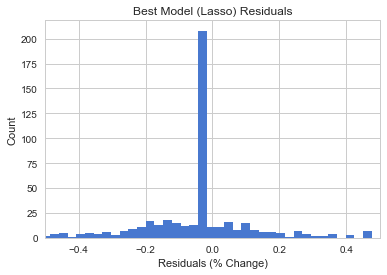

In [8]:
best_model.fit(X_train, y_train)
plt.title(f"""Best Model ({get_estimator_name(best_model)}) Residuals""")
plt.xlabel("Residuals (% Change)")
plt.ylabel("Count")
plt.xlim((-0.5, 0.5))
plt.hist((y_test - best_model.predict(X_test)).values, bins=250)
plt.savefig('../plots/Airbnb Price Trend Residual.png', bbox_inches='tight')
plt.show()

### Export Models

In [9]:
export_path = "../exported_models/airbnb_price_trends.hdf"
X_df.to_hdf(export_path, "X_df")
Y.to_hdf(export_path, "Y")

In [10]:
export_path = "../exported_models/airbnb_price_trends.pkl"
joblib.dump(best_model, export_path);

In [17]:
print(estimator_labels)
estimators[2].predict(X_test)

['Linear' 'Lasso' 'Ridge' 'OMP' 'BayesRidge' 'ElasticNet' 'RForest'
 'GBoosting']


array([-5.28196483e-02, -4.68811865e-02,  3.42950063e-01, -4.58997235e-02,
       -1.22554111e-01,  8.92020833e-02,  2.18490591e-01,  3.43799927e-02,
       -1.99896045e-02, -5.40438870e-02, -1.22955955e-02, -6.77420332e-02,
        5.44682366e-02, -5.55428057e-02, -5.92466963e-01,  9.10846127e-01,
       -4.31519185e-02,  6.23066981e-02,  8.45016426e-02,  4.25969753e-02,
       -8.44897209e-02,  8.50749891e-02,  9.63625310e-02, -2.75199680e-02,
       -2.68189320e-01, -1.01029231e-01, -1.48253950e-01, -2.65288317e-01,
       -2.96976478e-02,  2.30042262e-02,  3.19366337e-02, -1.92761662e-01,
        1.36784146e-01,  7.70453115e-03,  2.52174702e-02, -7.89357243e-02,
       -4.70762997e-02,  1.33417235e-01, -3.31852928e-02,  1.23262784e-01,
       -4.33558788e-02, -2.28567593e-02,  1.05028937e-01,  2.64204889e-01,
        1.03826801e-01,  3.07306036e-02, -1.13243684e-01,  1.48687854e-01,
       -2.33659912e-01, -1.05335614e-02,  6.40369039e-02,  3.60986051e-01,
       -3.62481936e-02,  